# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from collections import Counter

from utils.helper import IQR, cap_outliers_iqr, standard_scale, skewness, boxcox_transformation, VIF, shannon_entropy, train_test_split, plot_model_loss
from utils.metrics import classification_metrics, roc_auc_score, confusion_matrix
from utils.models import SVM, LogisticRegression
from utils.tuner import nested_cross_validation, generate_parameters

/Users/bercaakbayir/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Data Loading

In [2]:
RED_WINE_DATA = "./data/winequality-red.csv"
WHITE_WINE_DATA = "./data/winequality-white.csv"


In [3]:
wine_red = pd.read_csv(RED_WINE_DATA, sep=";")
wine_white = pd.read_csv(WHITE_WINE_DATA, sep=";")


In [4]:
red = wine_red.copy()
white = wine_white.copy()
red['wine_type'] = 'red'
white['wine_type'] = 'white'

# Combine the datasets
wines = pd.concat([red, white],axis=0, ignore_index=True)


# EDA

## Summary Statistics

In [5]:
wine_red.shape


(1599, 12)

In [6]:
wine_white.shape


(4898, 12)

In [7]:
wines.shape


(6497, 13)

In [8]:
wine_red.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [9]:
wine_white.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [10]:
wine_red.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [11]:
wine_white.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [12]:
wine_red.shape


(1599, 12)

In [13]:
wine_white.shape


(4898, 12)

## Missing Value Analysis

In [14]:
round((wine_red.isnull().sum() / len(wine_red)) * 100, 2)


fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                 0.0
dtype: float64

In [15]:
round((wine_white.isnull().sum() / len(wine_red)) * 100, 2)


fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                 0.0
dtype: float64

## Data Distribution

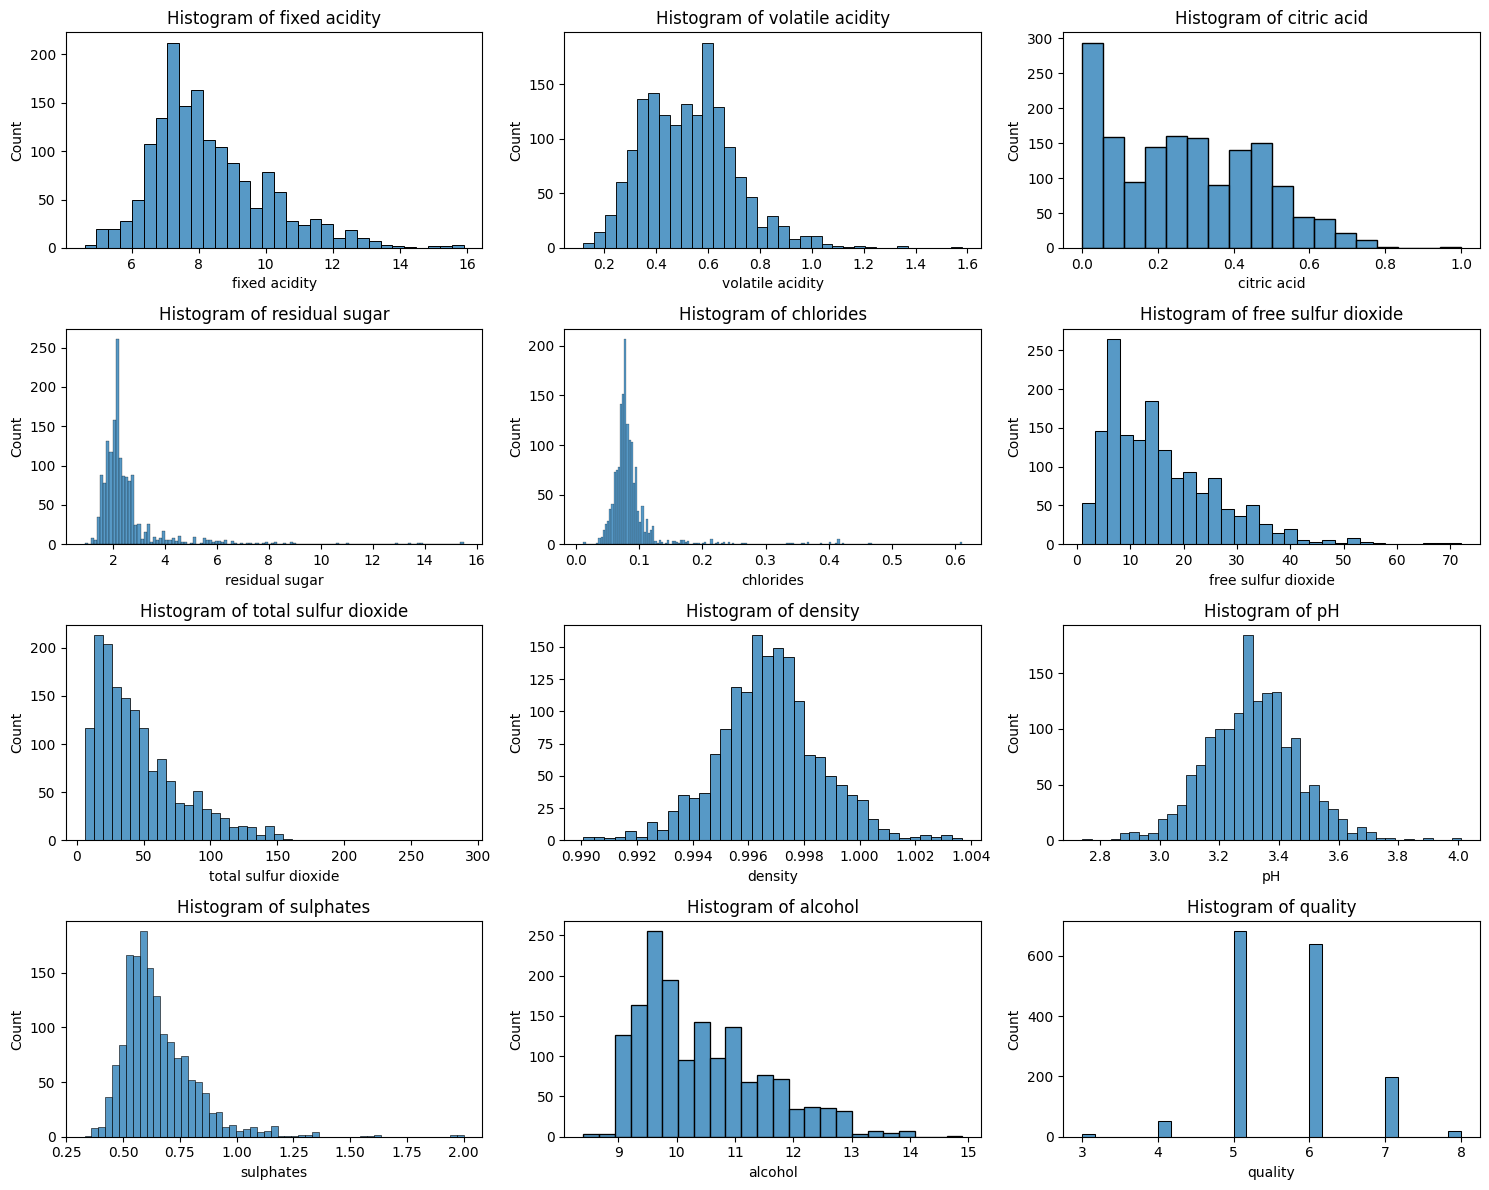

In [16]:
fig, axes = plt.subplots(4, 3, figsize=(15, 12))  
axes = axes.flatten()  

for i, col in enumerate(wine_red.columns):
    sns.histplot(data=wine_red, x=col, kde=False, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')

# Turn off any unused axes (if less than 12 features)
for j in range(len(wine_red.columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


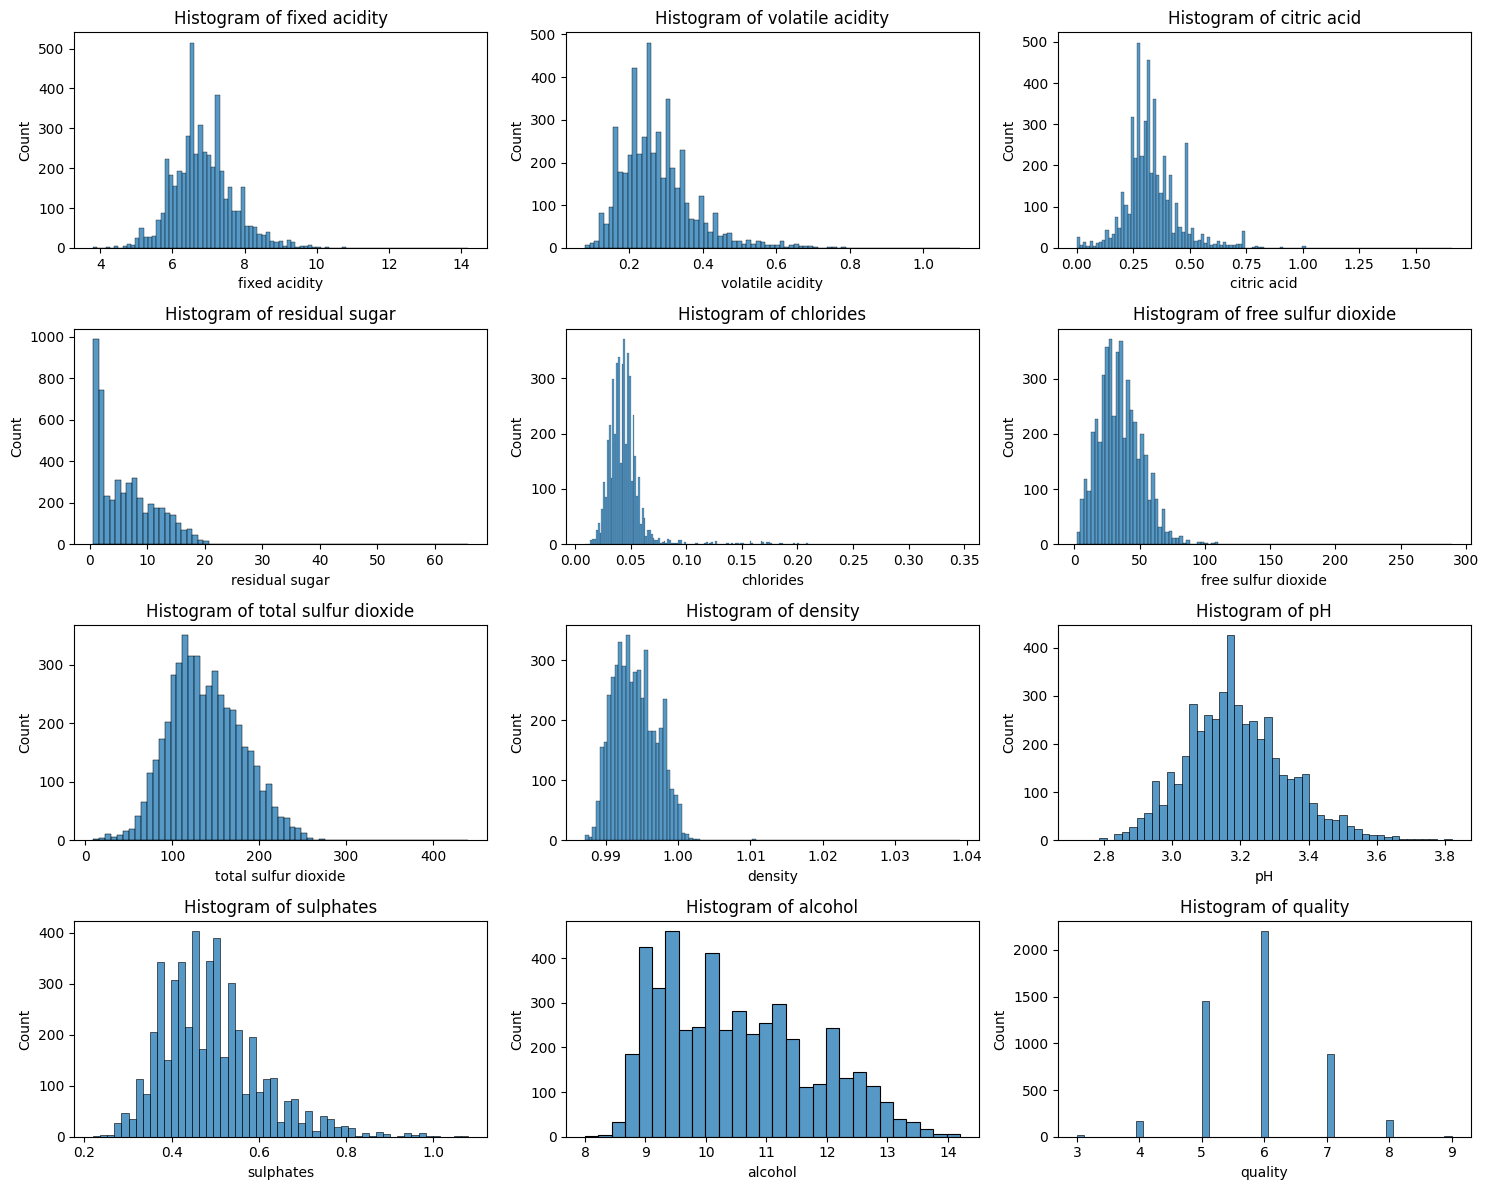

In [17]:
fig, axes = plt.subplots(4, 3, figsize=(15, 12))  
axes = axes.flatten()  

for i, col in enumerate(wine_white.columns):
    sns.histplot(data=wine_white, x=col, kde=False, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')

# Turn off any unused axes (if less than 12 features)
for j in range(len(wine_white.columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


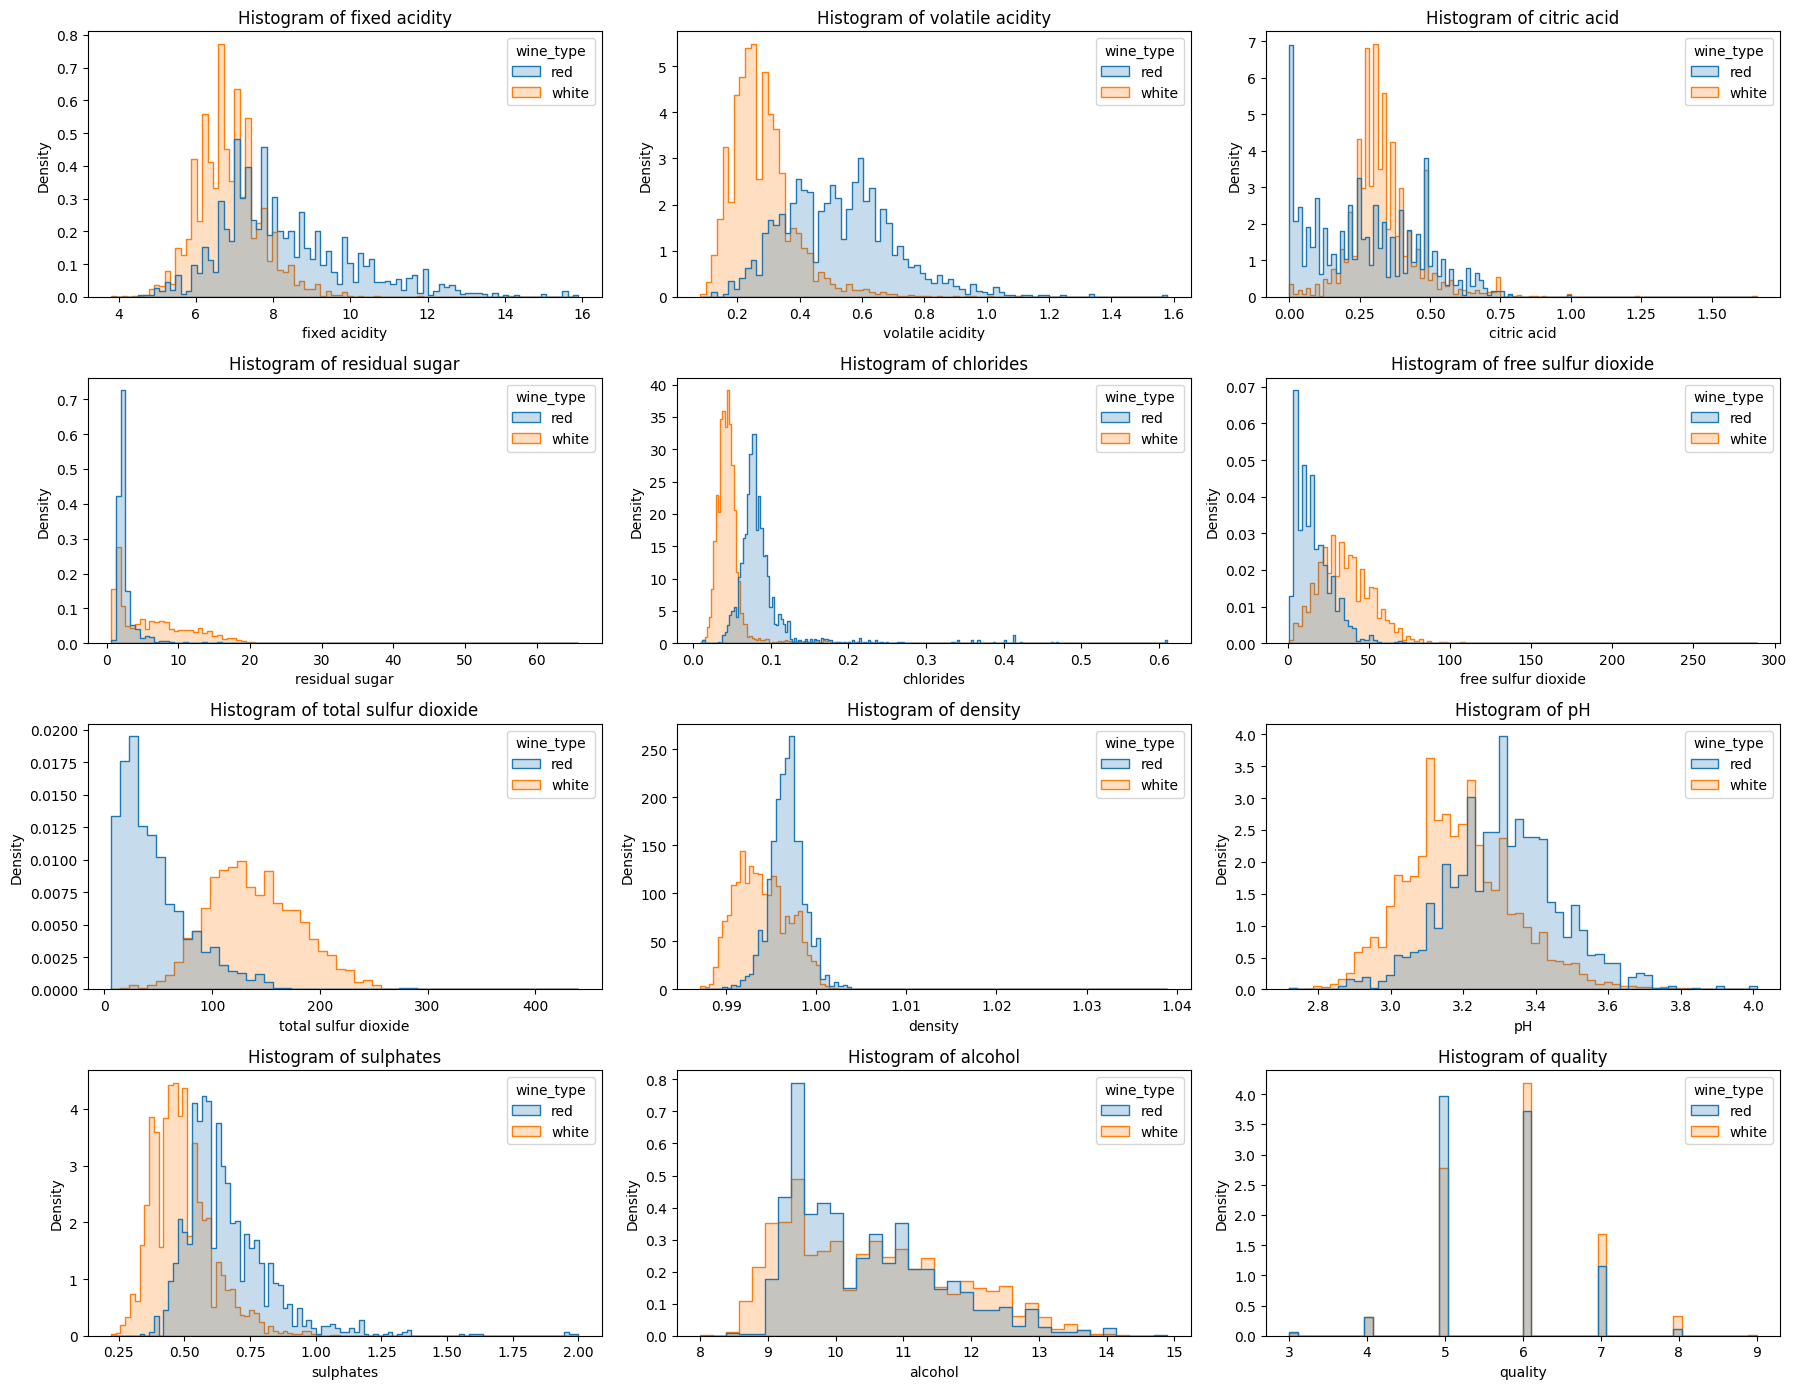

In [18]:
fig, axes = plt.subplots(4, 3, figsize=(18, 14))
axes = axes.flatten()
features = [col for col in wines.columns if col != 'wine_type']

# Plot histograms for each feature with hue for wine type
for i, col in enumerate(features):
    sns.histplot(data=wines, x=col, hue='wine_type', kde=False, ax=axes[i], 
                 element='step', stat='density', common_norm=False, legend=True)
    axes[i].set_title(f'Histogram of {col}')

# Hide unused axes if any
for j in range(len(features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [19]:
# Separate features
features = [col for col in wines.columns if col != 'wine_type']


# Store results
results = []

for col in features:
    stat, p = mannwhitneyu(wine_red[col], wine_white[col], alternative='two-sided')
    results.append({
        'Feature': col,
        'U-statistic': stat,
        'p-value': p,
        'Significant': 'Yes' if p < 0.05 else 'No'
    })

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values('p-value')

print(results_df)


                 Feature  U-statistic        p-value Significant
1       volatile acidity    7059623.5   0.000000e+00         Yes
4              chlorides    7407015.5   0.000000e+00         Yes
5    free sulfur dioxide    1186396.5   0.000000e+00         Yes
6   total sulfur dioxide     366639.5   0.000000e+00         Yes
9              sulphates    6509961.0   0.000000e+00         Yes
0          fixed acidity    6138507.0  1.438930e-255         Yes
7                density    6059284.5  1.453091e-237         Yes
8                     pH    5681839.5  5.472258e-162         Yes
3         residual sugar    2569687.0   5.634073e-95         Yes
2            citric acid    3070088.5   1.312558e-38         Yes
11               quality    3311514.0   3.634341e-23         Yes
10               alcohol    3829043.5   1.818451e-01          No


## Correlation Analysis

<Figure size 2000x2000 with 0 Axes>

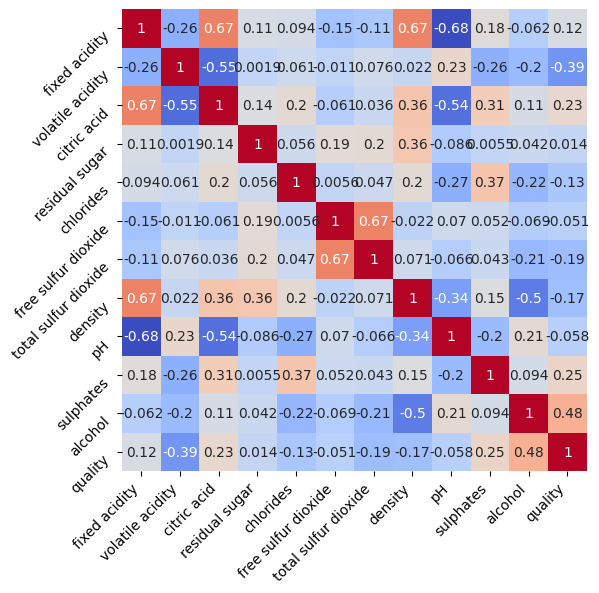

In [20]:
fig = plt.figure(figsize=(20, 20))

correlation = wine_red[wine_red.columns].corr()

plt.figure(figsize=(6, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", cbar=False)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45, va="top")

plt.show()


<Figure size 2000x2000 with 0 Axes>

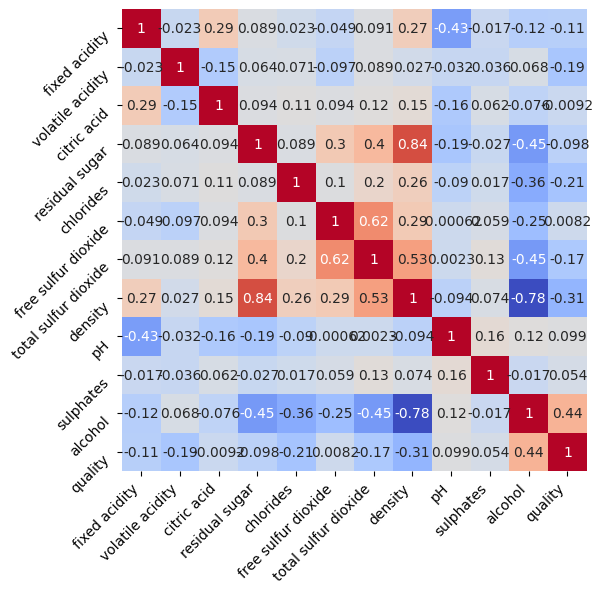

In [21]:
fig = plt.figure(figsize=(20, 20))

correlation = wine_white[wine_white.columns].corr()

plt.figure(figsize=(6, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", cbar=False)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45, va="top")

plt.show()


## Target Base Analysis

In [22]:
def wine_quality_categorization(quality):
    if quality >= 6:
        return "good"
    else:
        return "bad"

In [23]:
wine_red["quality"] = wine_red["quality"].apply(wine_quality_categorization)
wine_white["quality"] = wine_white["quality"].apply(wine_quality_categorization)
wines["quality"] = wines["quality"].apply(wine_quality_categorization)


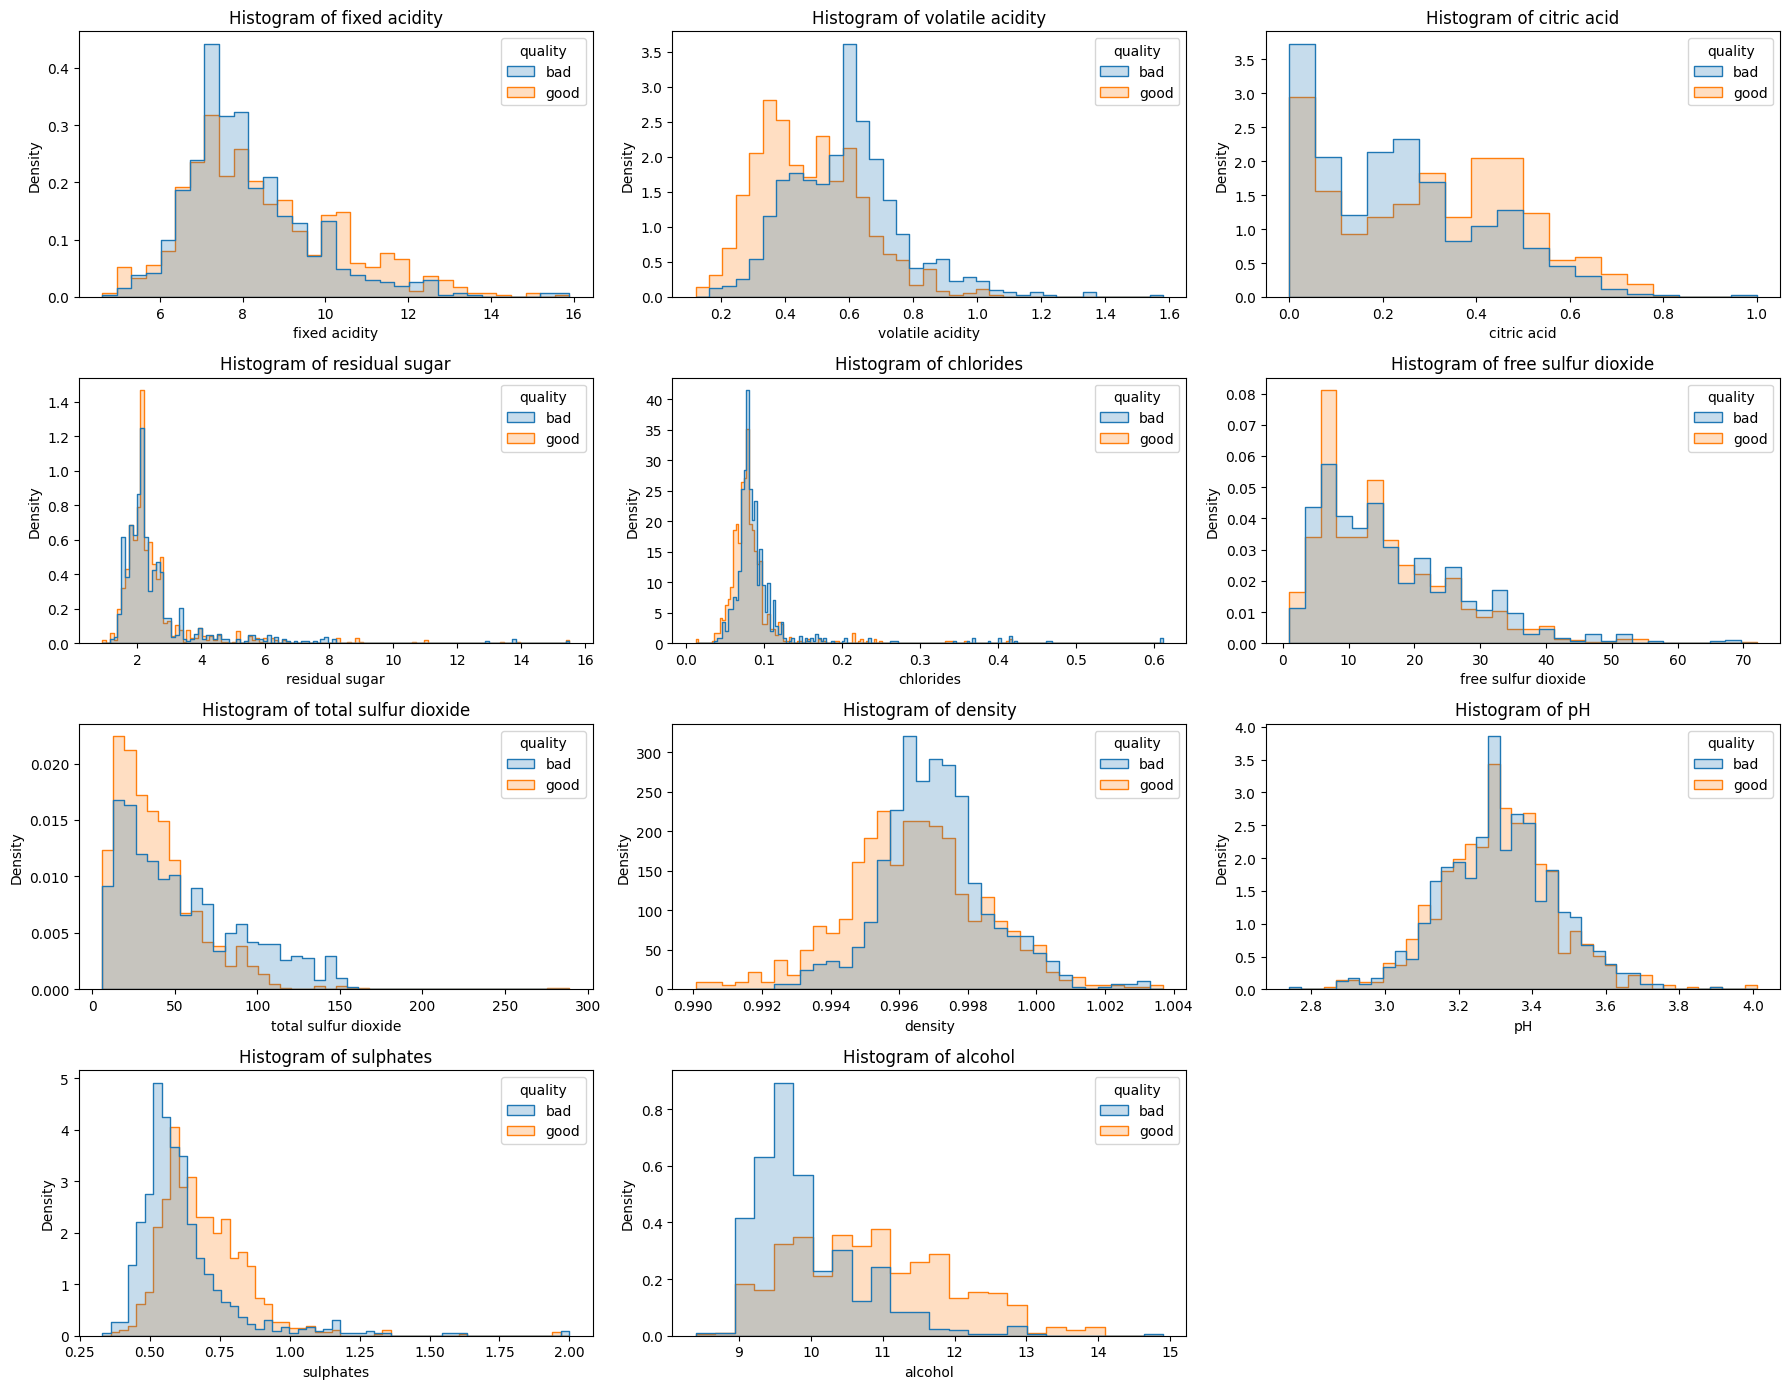

In [24]:
fig, axes = plt.subplots(4, 3, figsize=(18, 14))
axes = axes.flatten()
features = [col for col in wine_red.columns if col != 'quality']

for i, col in enumerate(features):
    sns.histplot(data=wine_red, x=col, hue='quality', kde=False, ax=axes[i], 
                 element='step', stat='density', common_norm=False, legend=True)
    axes[i].set_title(f'Histogram of {col}')

# Hide unused axes if any
for j in range(len(features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [25]:
# Separate features
features = [col for col in wines.columns if col != 'quality' and col != 'wine_type']

wine_red_good_quality = wine_red[wine_red['quality'] == "good"]
wine_red_bad_quality = wine_red[wine_red['quality'] == "bad"]

# Store results
results = []

for col in features:
    stat, p = mannwhitneyu(wine_red_good_quality[col], wine_red_bad_quality[col], alternative='two-sided')
    results.append({
        'Feature': col,
        'U-statistic': stat,
        'p-value': p,
        'Significant': 'Yes' if p < 0.05 else 'No'
    })

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values('p-value')

print(results_df)


                 Feature  U-statistic       p-value Significant
10               alcohol     481313.0  2.006059e-70         Yes
9              sulphates     440968.0  1.177947e-40         Yes
1       volatile acidity     197208.0  2.388474e-39         Yes
6   total sulfur dioxide     245006.0  2.136143e-15         Yes
4              chlorides     254091.0  3.719107e-12         Yes
7                density     257552.0  5.019222e-11         Yes
2            citric acid     376272.5  2.554688e-10         Yes
0          fixed acidity     347895.5  1.193549e-03         Yes
5    free sulfur dioxide     298401.5  3.263965e-02         Yes
3         residual sugar     323150.5  5.797433e-01          No
8                     pH     316157.5  8.363422e-01          No


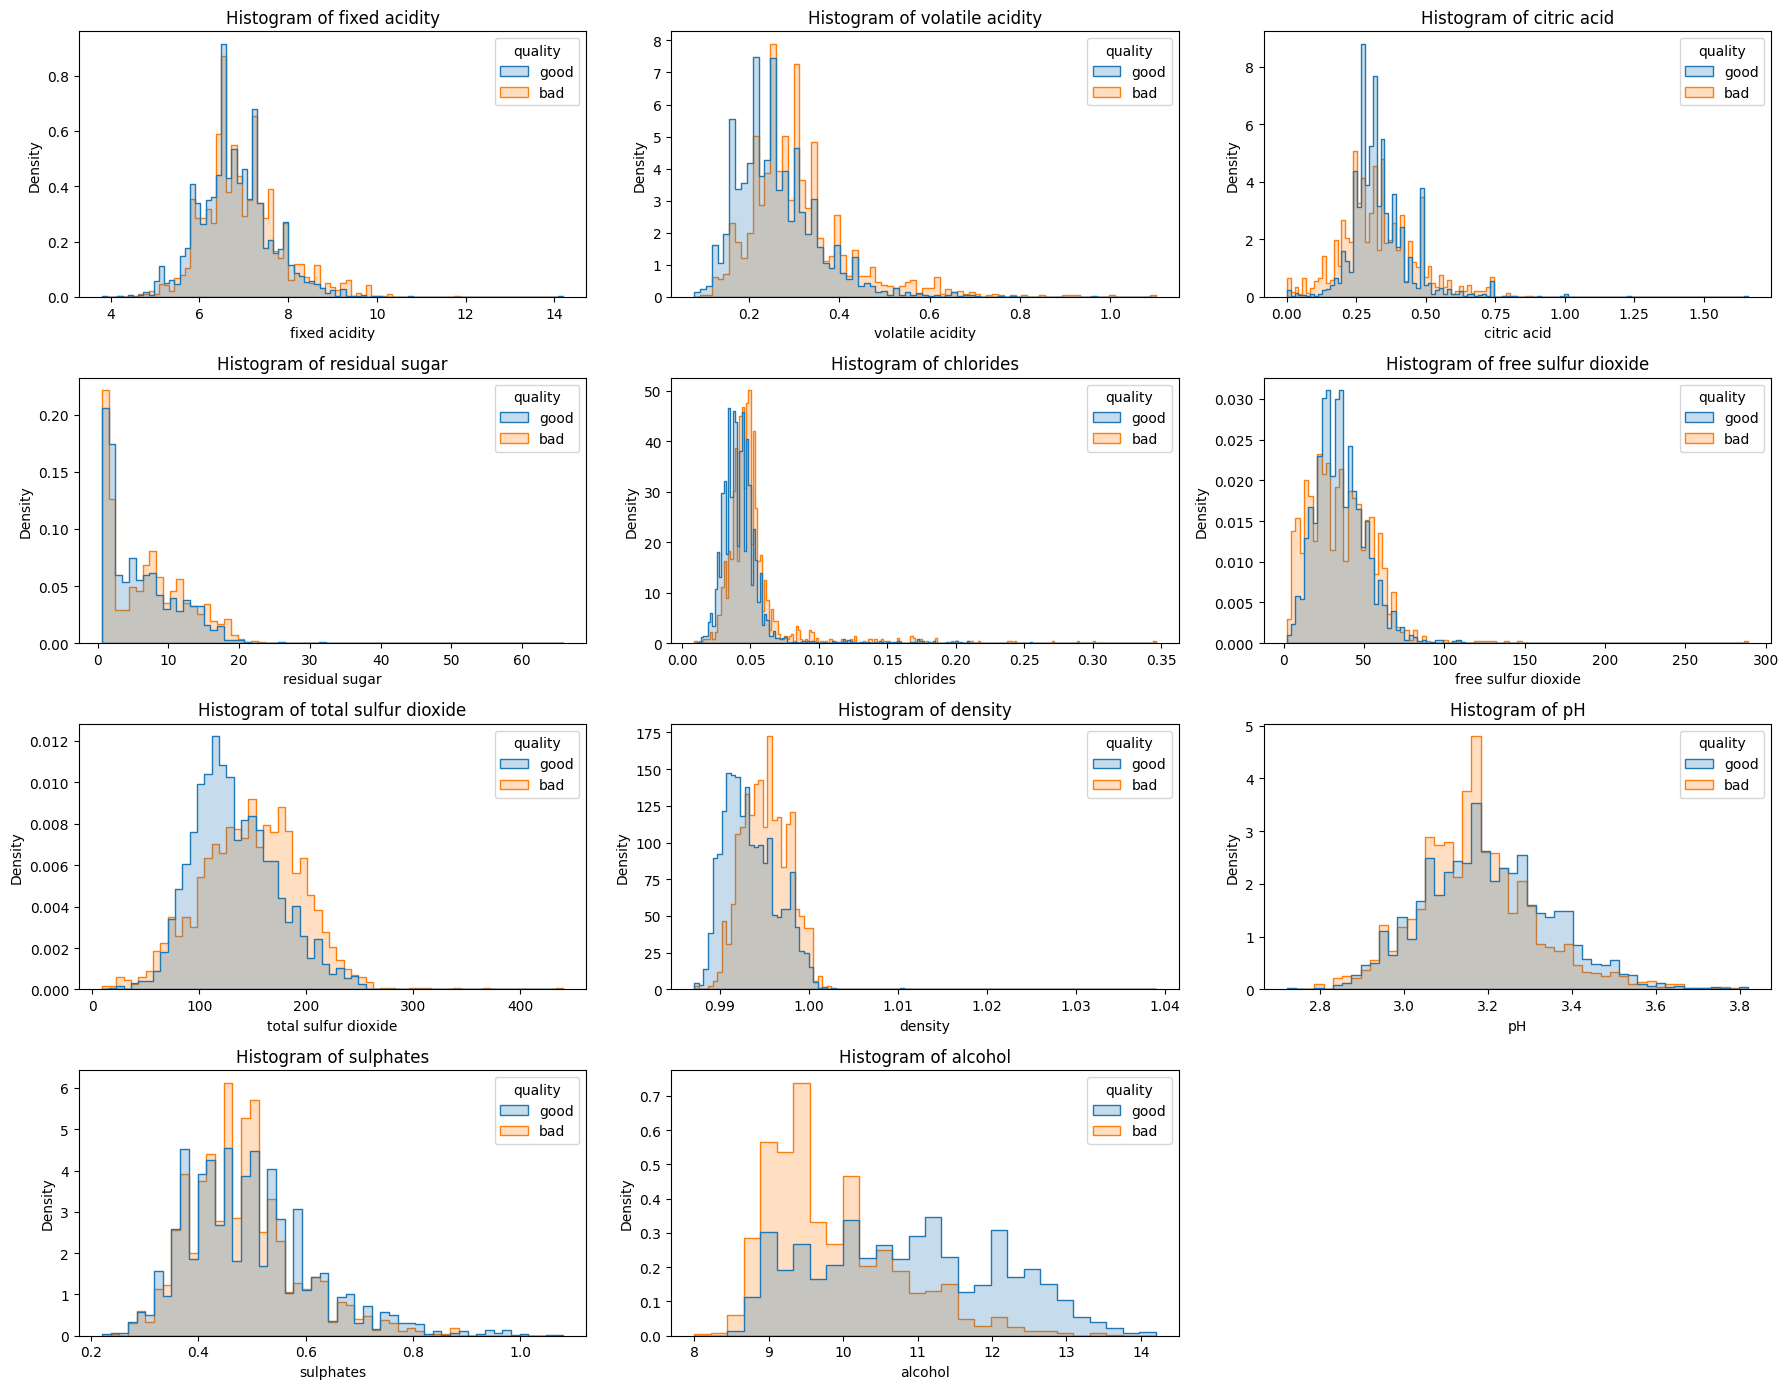

In [26]:
fig, axes = plt.subplots(4, 3, figsize=(18, 14))
axes = axes.flatten()
features = [col for col in wine_white.columns if col != 'quality']

for i, col in enumerate(features):
    sns.histplot(data=wine_white, x=col, hue='quality', kde=False, ax=axes[i], 
                 element='step', stat='density', common_norm=False, legend=True)
    axes[i].set_title(f'Histogram of {col}')

# Hide unused axes if any
for j in range(len(features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



In [27]:
# Separate features
features = [col for col in wines.columns if col != 'quality' and col != 'wine_type']

wine_white_good_quality = wine_white[wine_white['quality'] == "good"]
wine_white_bad_quality = wine_white[wine_white['quality'] == "bad"]

# Store results
results = []

for col in features:
    stat, p = mannwhitneyu(wine_white_good_quality[col], wine_white_bad_quality[col], alternative='two-sided')
    results.append({
        'Feature': col,
        'U-statistic': stat,
        'p-value': p,
        'Significant': 'Yes' if p < 0.05 else 'No'
    })

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values('p-value')

print(results_df)


                 Feature  U-statistic        p-value Significant
10               alcohol    3926540.5  3.696843e-159         Yes
7                density    1720368.0   3.326107e-92         Yes
4              chlorides    1819301.0   1.876827e-74         Yes
1       volatile acidity    1921500.5   4.123077e-58         Yes
6   total sulfur dioxide    2086080.5   4.735901e-36         Yes
8                     pH    2966022.0   2.858839e-10         Yes
0          fixed acidity    2430583.0   2.419737e-07         Yes
3         residual sugar    2439309.5   6.578255e-07         Yes
9              sulphates    2781642.0   1.836787e-02         Yes
2            citric acid    2740210.5   1.413184e-01          No
5    free sulfur dioxide    2729002.5   2.186507e-01          No


## Outlier Analysis

In [28]:
IQR(wine_red)


Outlier Percentages per Column
fixed acidity           0.312695
volatile acidity        0.062539
citric acid             0.000000
residual sugar          5.503440
chlorides               4.190119
free sulfur dioxide     0.250156
total sulfur dioxide    0.125078
density                 0.000000
pH                      0.125078
sulphates               1.000625
alcohol                 0.000000
dtype: float64


In [29]:
IQR(wine_white)


Outlier Percentages per Column
fixed acidity           0.081666
volatile acidity        0.796243
citric acid             0.449163
residual sugar          0.020416
chlorides               2.674561
free sulfur dioxide     0.163332
total sulfur dioxide    0.040833
density                 0.061249
pH                      0.000000
sulphates               0.224581
alcohol                 0.000000
dtype: float64


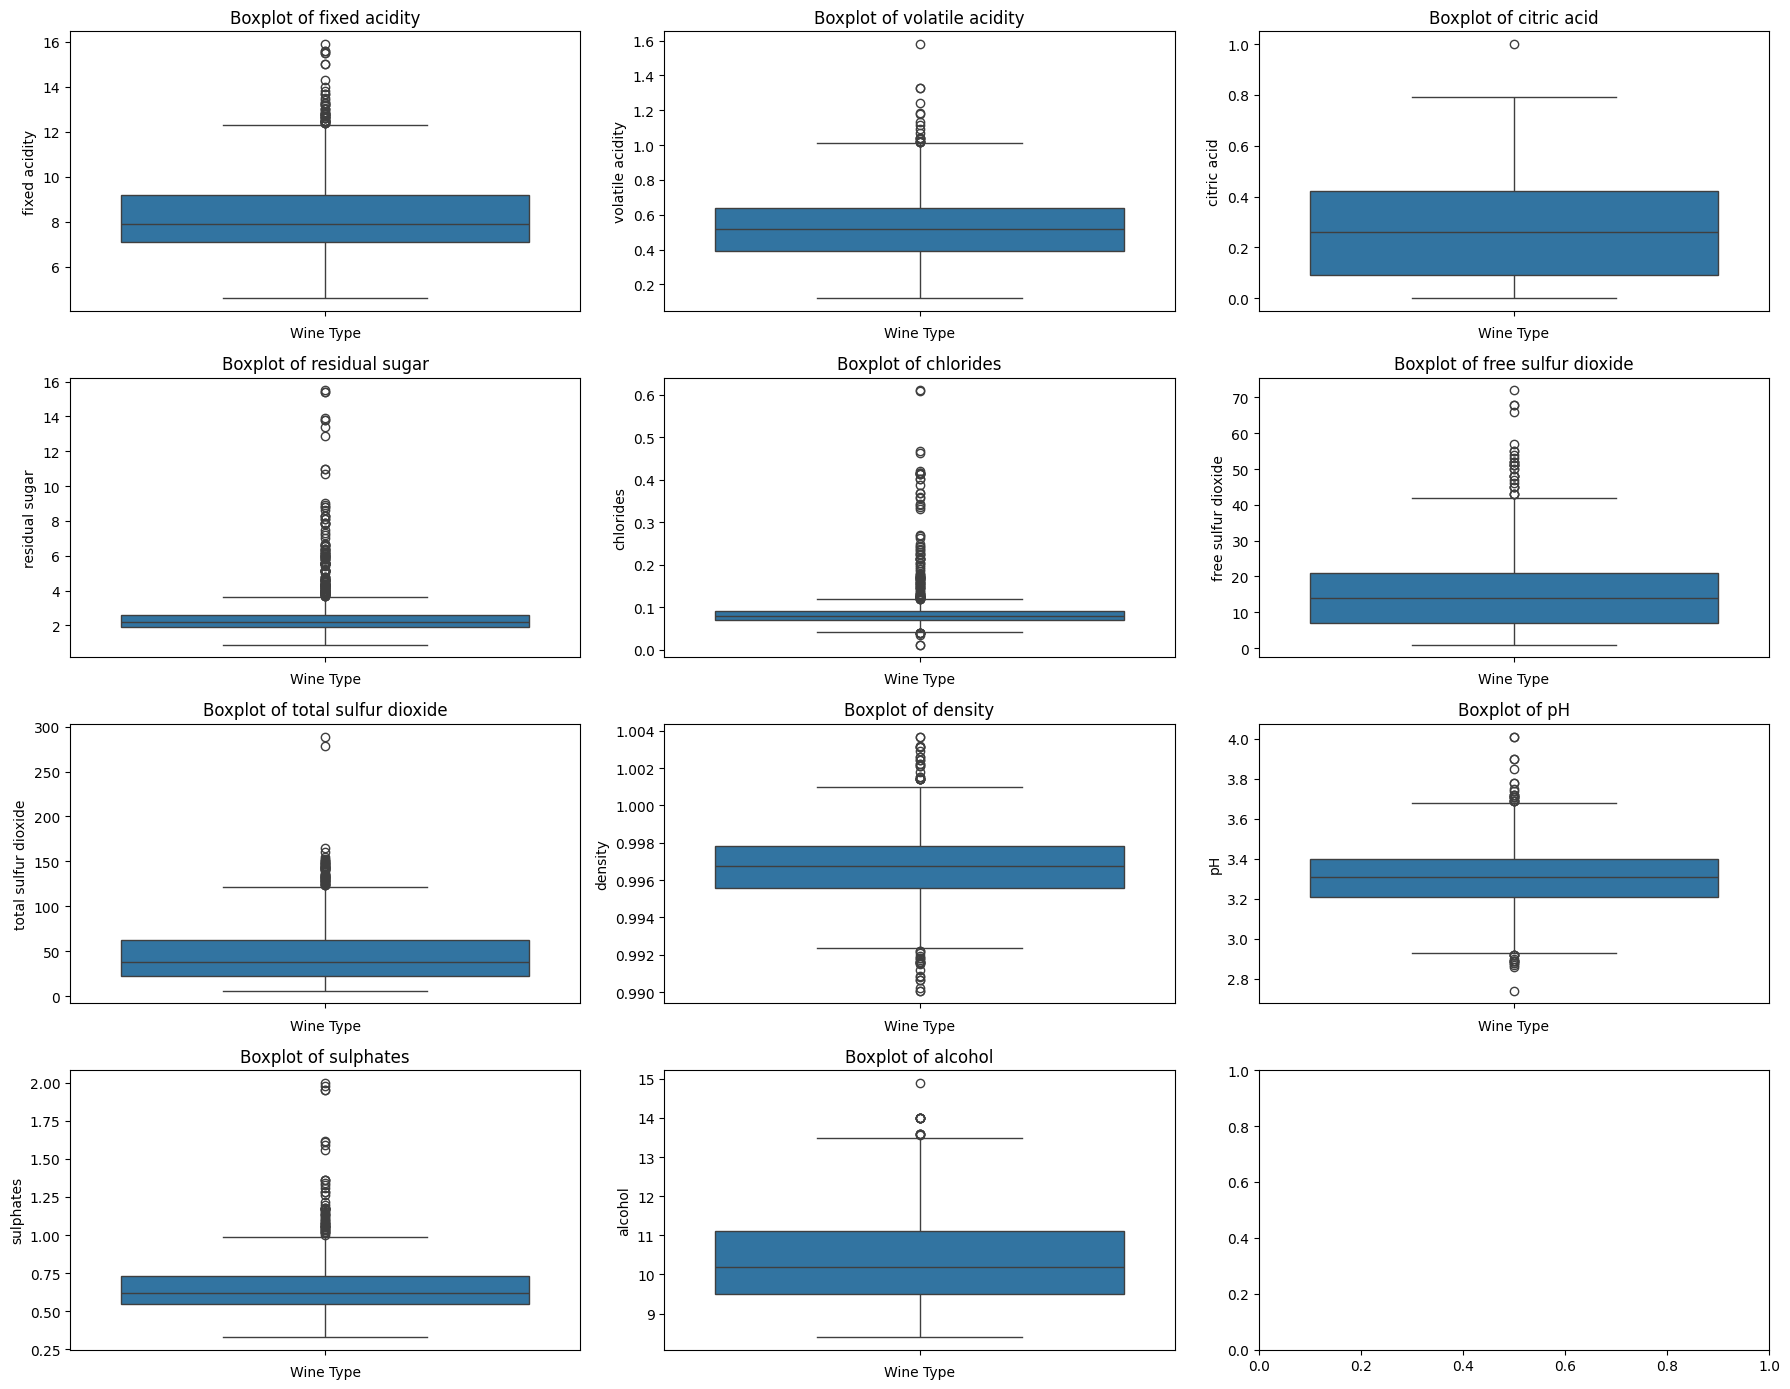

In [30]:
fig, axes = plt.subplots(4, 3, figsize=(18, 14))
axes = axes.flatten()
features = [col for col in wine_red.columns if col != 'quality']

for i, col in enumerate(features):
    sns.boxplot(data=wine_red, y=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel('Wine Type')
    axes[i].set_ylabel(col)


plt.tight_layout()
plt.show()


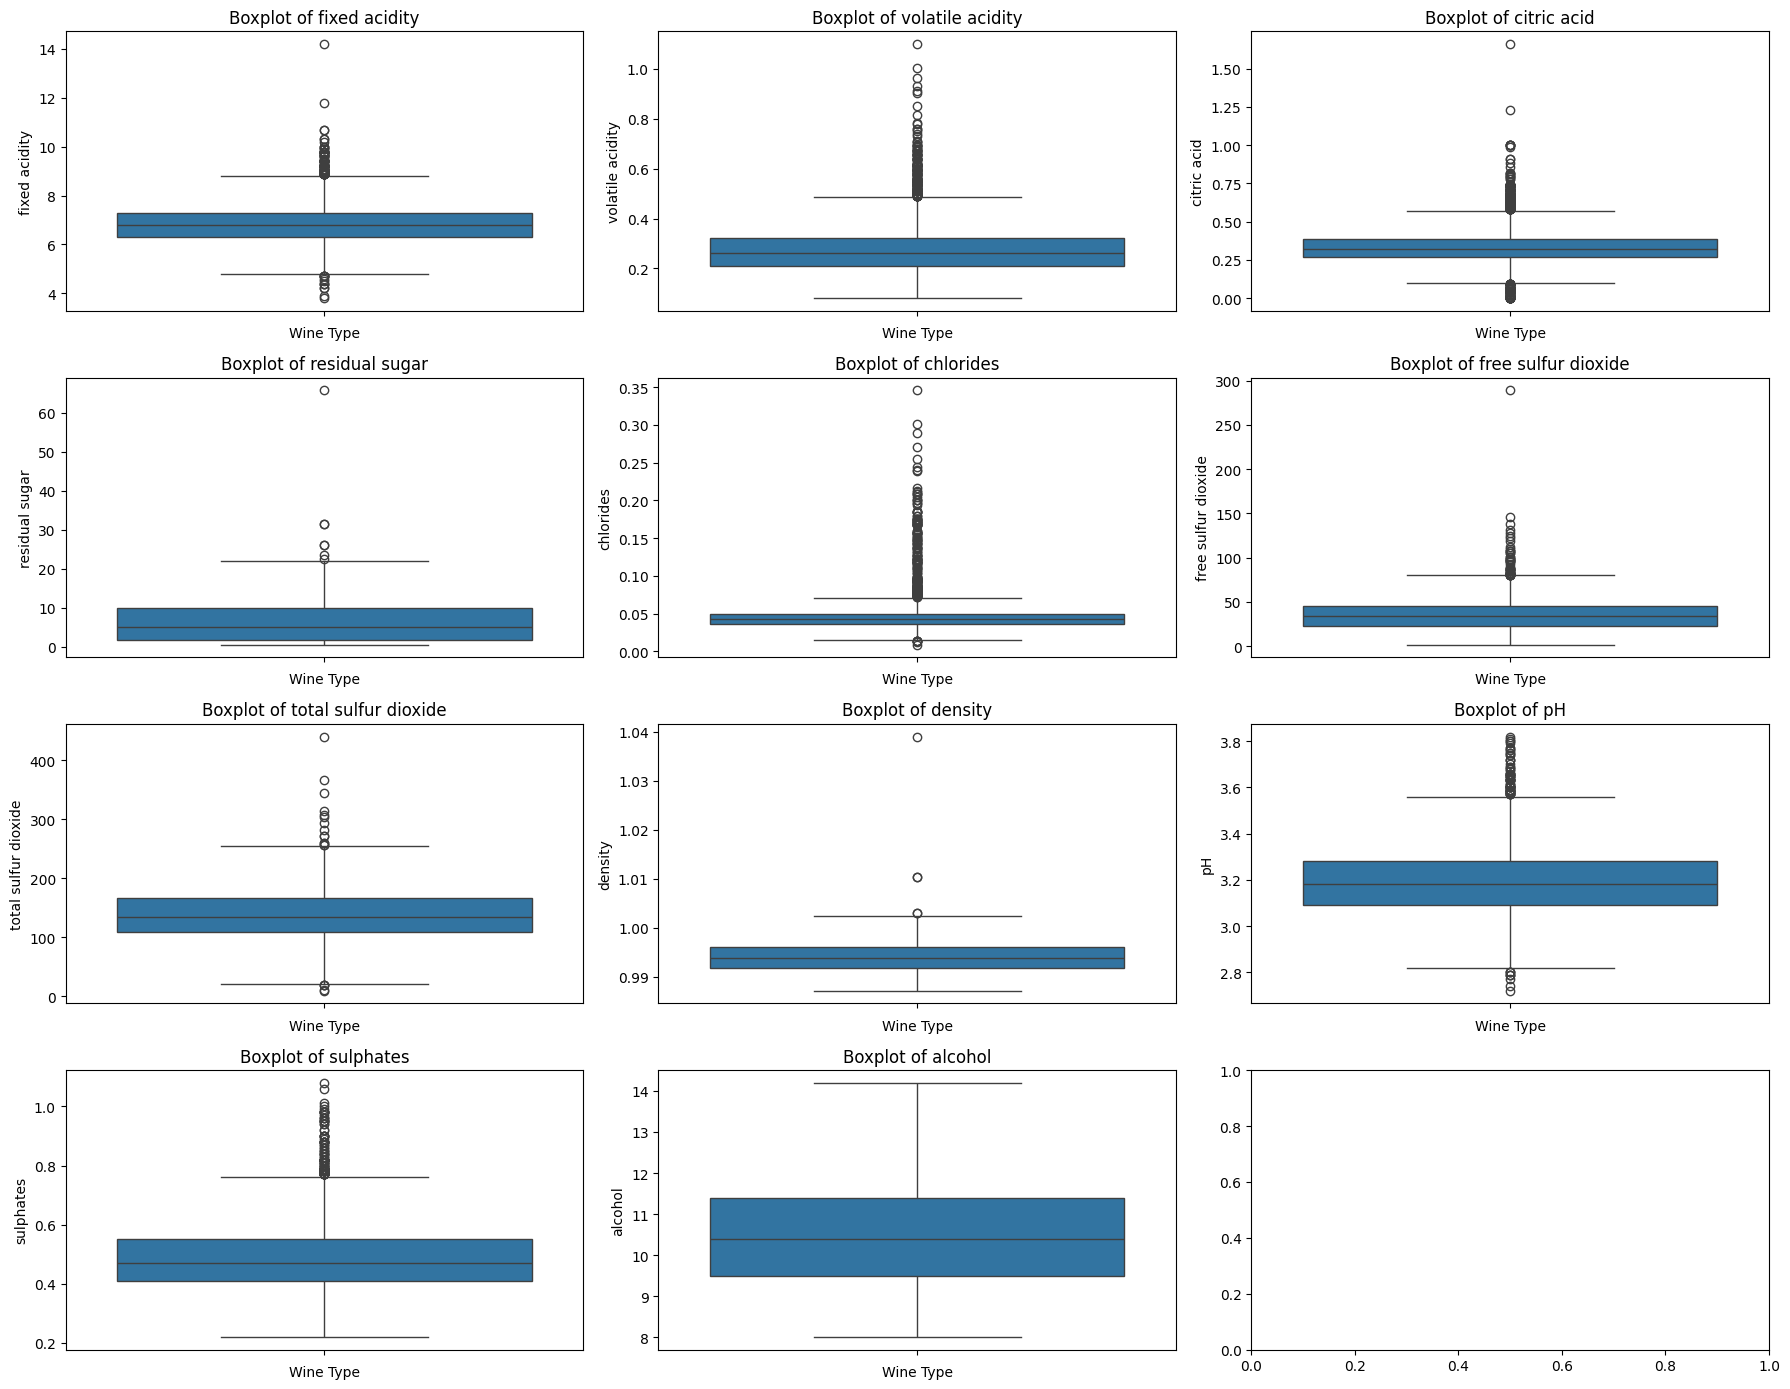

In [31]:
fig, axes = plt.subplots(4, 3, figsize=(18, 14))
axes = axes.flatten()
features = [col for col in wine_white.columns if col != 'quality']

for i, col in enumerate(features):
    sns.boxplot(data=wine_white, y=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel('Wine Type')
    axes[i].set_ylabel(col)


plt.tight_layout()
plt.show()


In [32]:
wine_red_capped = cap_outliers_iqr(wine_red)


In [33]:
wine_white_capped = cap_outliers_iqr(wine_white)


In [34]:
IQR(wine_red_capped)


Outlier Percentages per Column
fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
dtype: float64


In [35]:
IQR(wine_white_capped)


Outlier Percentages per Column
fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
dtype: float64


In [36]:
wine_red_capped.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319262,0.527702,0.270976,2.400938,0.082584,15.861163,46.340838,0.996747,3.311063,0.655297,10.422983
std,1.739515,0.178423,0.194801,0.805355,0.021734,10.393725,32.167066,0.001887,0.154166,0.154005,1.065668
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000
max,15.500000,1.390000,1.000000,4.700000,0.150000,63.000000,182.000000,1.003690,3.970000,1.270000,14.900000


In [37]:
wine_white_capped.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.853522,0.277486,0.333387,6.385024,0.044205,35.251327,138.336464,0.994021,3.188267,0.489775,10.514267
std,0.836515,0.097112,0.116886,5.016607,0.013387,16.540136,42.357375,0.002927,0.151001,0.113803,1.230621
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000
max,10.300000,0.650000,0.750000,34.500000,0.092000,115.000000,344.000000,1.009232,3.820000,0.970000,14.200000


## Data Scaling

In [38]:
wine_red_scaled = standard_scale(wine_red_capped)


In [39]:
wine_white_scaled = standard_scale(wine_white_capped)


## Skewness & Data Transformation

In [40]:
for i in wine_red_scaled.columns:
    if i == 'quality':
        continue 
    print(f"skewness of {i} :", skewness(wine_red_scaled[i].values))
    

skewness of fixed acidity : 0.9745658713321573
skewness of volatile acidity : 0.6230127158605607
skewness of citric acid : 0.31833729525463994
skewness of residual sugar : 1.5855405351396161
skewness of chlorides : 1.220142920509384
skewness of free sulfur dioxide : 1.1852799171695965
skewness of total sulfur dioxide : 1.2241910537425822
skewness of density : 0.07128766294937752
skewness of pH : 0.17656938249597276
skewness of sulphates : 1.392824861555625
skewness of alcohol : 0.8608288068888564


In [41]:
for i in wine_white_scaled.columns:
    if i == 'quality':
        continue 
    print(f"skewness of {i} :", skewness(wine_white_scaled[i].values))
    

skewness of fixed acidity : 0.5064157477591454
skewness of volatile acidity : 1.1866665151283338
skewness of citric acid : 0.8129184638175131
skewness of residual sugar : 0.8136810980597464
skewness of chlorides : 1.3327136500895809
skewness of free sulfur dioxide : 0.7106416633340958
skewness of total sulfur dioxide : 0.3373857809257962
skewness of density : 0.32564411198937077
skewness of pH : 0.4577825459180736
skewness of sulphates : 0.9488214662414755
skewness of alcohol : 0.48734199321612864


In [42]:
cols_to_check = [col for col in wine_white_scaled.columns if col != 'quality']

wine_red_transformed, lambdas_red = boxcox_transformation(wine_red_scaled, cols_to_check)
wine_white_transformed, lambdas_white = boxcox_transformation(wine_white_scaled, cols_to_check)


Skipped columns (skewness ≤ 0.5): ['citric acid', 'density', 'pH']
Skipped columns (skewness ≤ 0.5): ['total sulfur dioxide', 'density', 'pH', 'alcohol']


In [43]:
for i in wine_red_transformed.columns:
    if i == 'quality':
        continue 
    print(f"skewness of {i} :", skewness(wine_red_transformed[i].values))
    

skewness of fixed acidity : 0.059626294852913556
skewness of volatile acidity : -0.012785648407869837
skewness of citric acid : 0.31833729525463994
skewness of residual sugar : 0.36932921827131393
skewness of chlorides : 0.3278433295003164
skewness of free sulfur dioxide : -0.007911296649677576
skewness of total sulfur dioxide : 0.0008752539959990049
skewness of density : 0.07128766294937752
skewness of pH : 0.17656938249597276
skewness of sulphates : 0.11088214526401764
skewness of alcohol : 0.06598149499989103


In [44]:
for i in wine_white_transformed.columns:
    if i == 'quality':
        continue 
    print(f"skewness of {i} :", skewness(wine_white_transformed[i].values))
    

skewness of fixed acidity : 0.05672462251341873
skewness of volatile acidity : 0.06700437169955374
skewness of citric acid : 0.042455056089274947
skewness of residual sugar : -0.1400049169320257
skewness of chlorides : 0.12496880859425173
skewness of free sulfur dioxide : 0.00742258539241399
skewness of total sulfur dioxide : 0.3373857809257962
skewness of density : 0.32564411198937077
skewness of pH : 0.4577825459180736
skewness of sulphates : 0.051007028592153975
skewness of alcohol : 0.48734199321612864


## Multicolinearity Analysis

In [45]:
X_red = wine_red_transformed.drop(columns='quality') 
vif_df = VIF(X_red)
print(vif_df.sort_values(by='VIF', ascending=False))


                 Feature       VIF
0          fixed acidity  6.926378
7                density  6.244743
8                     pH  3.258343
6   total sulfur dioxide  2.935470
2            citric acid  2.822823
10               alcohol  2.774575
5    free sulfur dioxide  2.626571
1       volatile acidity  1.811095
3         residual sugar  1.793963
4              chlorides  1.358168
9              sulphates  1.336254


In [46]:
X_white = wine_white_transformed.drop(columns='quality') 
vif_df = VIF(X_white)
print(vif_df.sort_values(by='VIF', ascending=False))


                 Feature        VIF
7                density  16.102141
10               alcohol   6.449760
3         residual sugar   6.341205
6   total sulfur dioxide   2.285906
0          fixed acidity   2.137924
5    free sulfur dioxide   1.797676
8                     pH   1.739296
4              chlorides   1.458058
2            citric acid   1.184455
1       volatile acidity   1.164606
9              sulphates   1.110128


## Target Balance Analysis

In [47]:
entropy = shannon_entropy(wine_red_transformed["quality"])
entropy


0.996521092260499

In [48]:
entropy = shannon_entropy(wine_white_transformed["quality"])
entropy


0.9197857727319919

In [49]:
def plot_target_distribution(df, target_col):
    # Calculate value counts and percentages
    counts = df[target_col].value_counts()
    percentages = counts / counts.sum() * 100

    # Prepare the plot
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=counts.index, y=percentages, palette='viridis')

    # Add percentage labels on top of bars
    for p, perc in zip(ax.patches, percentages):
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 1,
                f'{perc:.1f}%', ha='center', fontsize=12)

    plt.ylabel('Percentage (%)')
    plt.xlabel(target_col)
    plt.title(f'Distribution of {target_col} (in %)')
    plt.ylim(0, percentages.max() + 10)
    plt.show()


/var/folders/dd/6c1yw5255dd59m89xkwwf4qr0000gn/T/ipykernel_32998/533642084.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=percentages, palette='viridis')


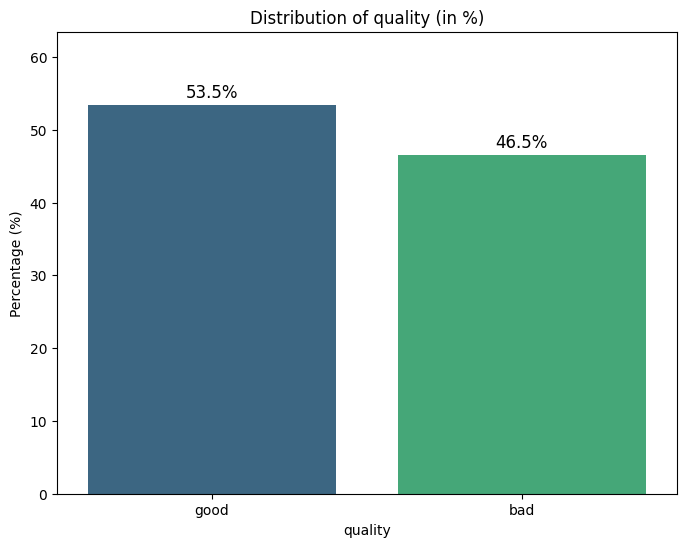

In [50]:
plot_target_distribution(wine_red_transformed, 'quality')


/var/folders/dd/6c1yw5255dd59m89xkwwf4qr0000gn/T/ipykernel_32998/533642084.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=percentages, palette='viridis')


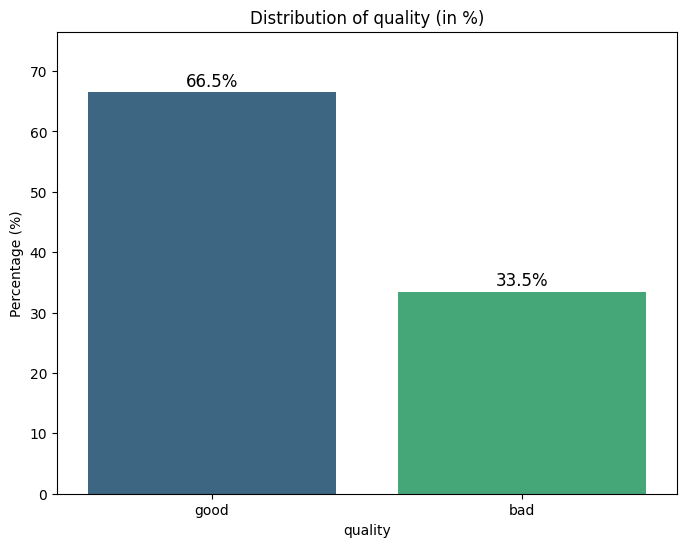

In [51]:
plot_target_distribution(wine_white_transformed, 'quality')


# Modeling

## Red Wine Quality Classification

### Train - Test Splitting

In [52]:
X_red = wine_red_transformed.drop("quality", axis=1)
y_red = wine_red_transformed["quality"]


In [53]:
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red, test_size=0.2, random_state=42)


### SVM

In [54]:
svm = SVM(kernel='linear', learning_rate=0.001, n_iters=100)  # linear SVM with SGD

svm.fit(X_red_train, y_red_train, X_test=X_red_test, y_test = y_red_test)

preds_red_svm = svm.predict(X_red_test)
metrics = classification_metrics(y_red_test, preds_red_svm)
for k, v in metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")

Epoch 1: Train Loss=0.7206, Train Accuracy=0.7164 | Test Loss=0.7102, Test Accuracy=0.7241
Epoch 2: Train Loss=0.6481, Train Accuracy=0.7234 | Test Loss=0.6526, Test Accuracy=0.7241
Epoch 3: Train Loss=0.6281, Train Accuracy=0.7297 | Test Loss=0.6370, Test Accuracy=0.7304
Epoch 4: Train Loss=0.6187, Train Accuracy=0.7336 | Test Loss=0.6288, Test Accuracy=0.7367
Epoch 5: Train Loss=0.6123, Train Accuracy=0.7359 | Test Loss=0.6226, Test Accuracy=0.7429
Epoch 6: Train Loss=0.6076, Train Accuracy=0.7375 | Test Loss=0.6174, Test Accuracy=0.7492
Epoch 7: Train Loss=0.6043, Train Accuracy=0.7438 | Test Loss=0.6139, Test Accuracy=0.7524
Epoch 8: Train Loss=0.6018, Train Accuracy=0.7438 | Test Loss=0.6112, Test Accuracy=0.7524
Epoch 9: Train Loss=0.5997, Train Accuracy=0.7477 | Test Loss=0.6082, Test Accuracy=0.7555
Epoch 10: Train Loss=0.5984, Train Accuracy=0.7469 | Test Loss=0.6066, Test Accuracy=0.7586
Epoch 11: Train Loss=0.5970, Train Accuracy=0.7453 | Test Loss=0.6050, Test Accuracy=0.75

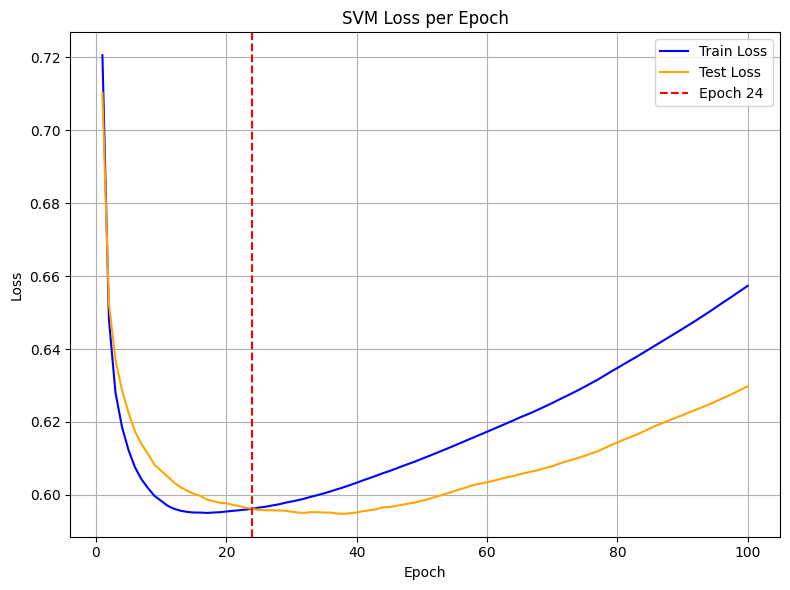

In [55]:
plot_model_loss(svm, vline_epoch=24, train_color='blue', test_color='orange')


### Logistic Regression

In [62]:

logreg = LogisticRegression(
    learning_rate=1e-5, n_iters=500, kernel='linear', gamma=0.1,
    positive_class='good', l2=0.001
)
logreg.fit(X_red_train, y_red_train, X_test=X_red_test, y_test = y_red_test)

preds_red_logreg = logreg.predict(X_red_test)
metrics = classification_metrics(y_red_test, preds_red_logreg)
for k, v in metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")

[Epoch 1/500] Train Loss: 0.6921 | Accuracy: 0.5281 || Test Loss: 0.6918 | Accuracy: 0.5643
[Epoch 2/500] Train Loss: 0.6911 | Accuracy: 0.5281 || Test Loss: 0.6906 | Accuracy: 0.5643
[Epoch 3/500] Train Loss: 0.6901 | Accuracy: 0.5281 || Test Loss: 0.6894 | Accuracy: 0.5643
[Epoch 4/500] Train Loss: 0.6892 | Accuracy: 0.5297 || Test Loss: 0.6882 | Accuracy: 0.5674
[Epoch 5/500] Train Loss: 0.6883 | Accuracy: 0.5312 || Test Loss: 0.6871 | Accuracy: 0.5705
[Epoch 6/500] Train Loss: 0.6874 | Accuracy: 0.5328 || Test Loss: 0.6861 | Accuracy: 0.5705
[Epoch 7/500] Train Loss: 0.6866 | Accuracy: 0.5398 || Test Loss: 0.6851 | Accuracy: 0.5768
[Epoch 8/500] Train Loss: 0.6857 | Accuracy: 0.5453 || Test Loss: 0.6841 | Accuracy: 0.5925
[Epoch 9/500] Train Loss: 0.6849 | Accuracy: 0.5469 || Test Loss: 0.6831 | Accuracy: 0.5956
[Epoch 10/500] Train Loss: 0.6841 | Accuracy: 0.5563 || Test Loss: 0.6822 | Accuracy: 0.6050
[Epoch 11/500] Train Loss: 0.6833 | Accuracy: 0.5633 || Test Loss: 0.6813 | Acc

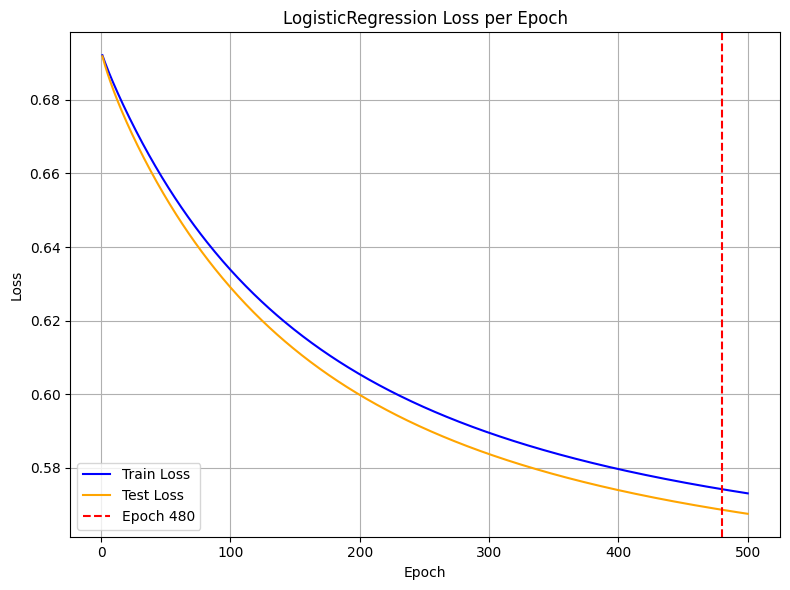

In [64]:
plot_model_loss(logreg, vline_epoch=480, train_color='blue', test_color='orange')

### Hyperparameter Tuning with CV & Model Comparison

In [58]:
svm_param_grid = {
    'learning_rate':[0.01, 0.1],
    'lambda_l2':[0.001, 0.01],
    'kernel' :['rbf', 'poly'],
    'gamma' : [0.01, 0.1],
    'C' :[0.01, 0.1]
}

In [59]:
svm_scores, svm_params = nested_cross_validation(
        X_red_train, y_red_train, svm, svm_param_grid, outer_k=5, inner_k=5, random_state=42
    )

Outer CV:   0%|          | 0/5 [00:20<?, ?it/s]                  


KeyboardInterrupt: 

In [ ]:
best_fold_idx = np.argmax(svm_scores)  
best_params = svm_params[best_fold_idx]

print("Best parameters (from best fold):", best_params)
print("Best fold score:", svm_scores[best_fold_idx])

In [ ]:
print("\nCross-validated performance:")
print(f"Mean accuracy: {np.mean(svm_scores):.3f} ± {np.std(svm_scores):.3f}")

In [ ]:
lr_param_grid = {
    'learning_rate':[0.01, 0.1],
    'l2':[0.001, 0.01],
    'kernel' :['linear', 'rbf', 'poly'],
    'gamma' : [0.01, 0.1],
    'degree': [2,3],
    'coef0': [1.0]

}

In [ ]:
lr_scores, lr_params = nested_cross_validation(
        X_red_train, y_red_train, logreg, lr_param_grid, outer_k=5, inner_k=5, random_state=42
    )

In [ ]:
best_fold_idx = np.argmax(lr_scores)  
best_params = lr_params[best_fold_idx]

print("Best parameters (from best fold):", best_params)
print("Best fold score:", lr_scores[best_fold_idx])

In [ ]:
print("\nCross-validated performance:")
print(f"Mean accuracy: {np.mean(lr_scores):.3f} ± {np.std(lr_scores):.3f}")

### Model Analysis

#### SVM

In [65]:
cm = confusion_matrix(y_red_test, preds_red_svm, positive_label='good')
cm

,Predicted good,Predicted not-good
Actual good,145,34
Actual not-good,52,88


In [66]:
svm_red_probs = svm.predict_proba(X_red_test)[:, 1]

In [67]:
fpr, tpr, auc = roc_auc_score(y_red_test, svm_red_probs, pos_label='good')

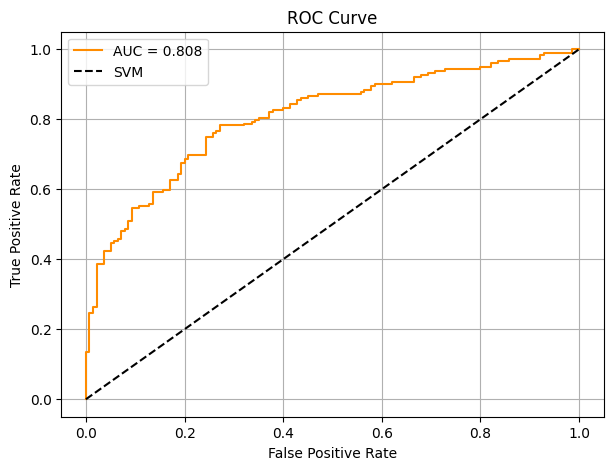

In [68]:
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}', color='darkorange')
plt.plot([0,1], [0,1], 'k--', label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

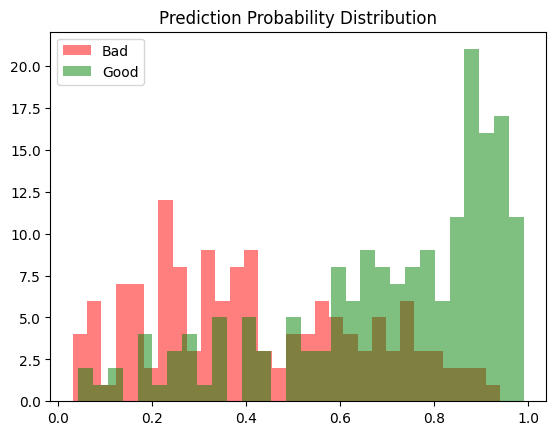

In [69]:
plt.hist(svm_red_probs[y_red_test == 'bad'], bins=30, alpha=0.5, label='Bad', color='red')
plt.hist(svm_red_probs[y_red_test == 'good'], bins=30, alpha=0.5, label='Good', color='green')
plt.title("Prediction Probability Distribution")
plt.legend()
plt.show()

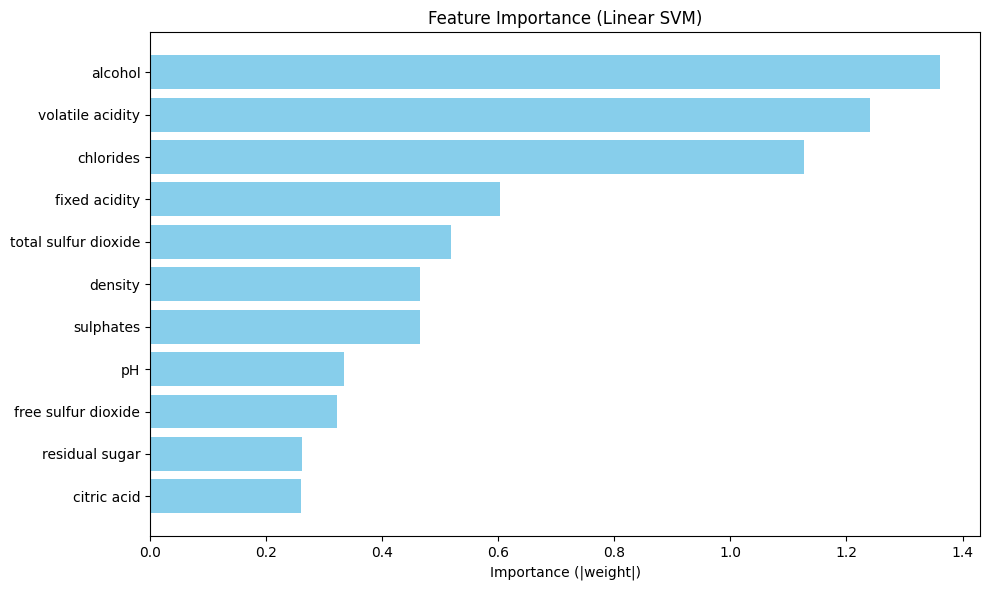

In [70]:
importances = svm.get_feature_importance(X_red.columns)
sorted_items = sorted(importances.items(), key=lambda x: -x[1])
features, values = zip(*sorted_items)

plt.figure(figsize=(10, 6))
plt.barh(features, values, color='skyblue')
plt.xlabel('Importance (|weight|)')
plt.title('Feature Importance (Linear SVM)')
plt.gca().invert_yaxis()  # Highest on top
plt.tight_layout()
plt.show()

#### Logistic Regression

In [71]:
cm = confusion_matrix(y_red_test, preds_red_logreg, positive_label='good')
cm

,Predicted good,Predicted not-good
Actual good,131,48
Actual not-good,41,99


In [72]:
logreg_red_probs = logreg.predict_proba(X_red_test)

In [73]:
fpr, tpr, auc = roc_auc_score(y_red_test, logreg_red_probs, pos_label='good')

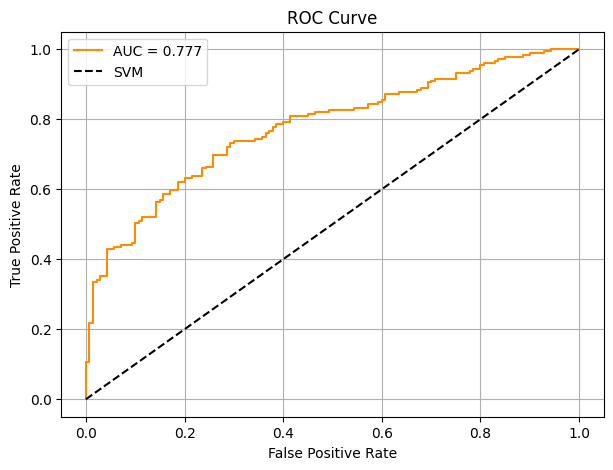

In [74]:
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}', color='darkorange')
plt.plot([0,1], [0,1], 'k--', label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

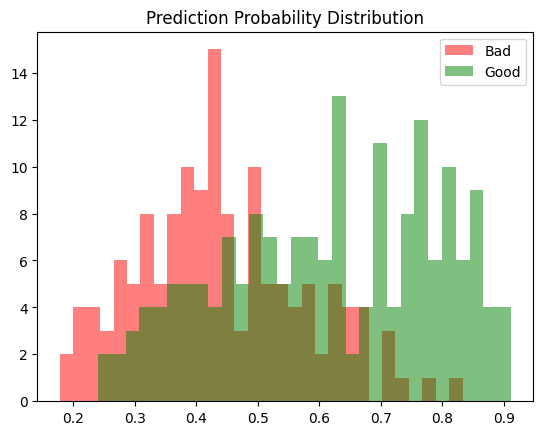

In [75]:
plt.hist(logreg_red_probs[y_red_test == 'bad'], bins=30, alpha=0.5, label='Bad', color='red')
plt.hist(logreg_red_probs[y_red_test == 'good'], bins=30, alpha=0.5, label='Good', color='green')
plt.title("Prediction Probability Distribution")
plt.legend()
plt.show()

In [76]:
feature_importance = logreg.get_feature_importance()

In [77]:
def plot_feature_importance(feature_importance, feature_names):
    # Sort features by absolute importance descending
    indices = np.argsort(np.abs(feature_importance))[::-1]
    sorted_importance = feature_importance[indices]
    sorted_features = [feature_names[i] for i in indices]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(sorted_features, sorted_importance, color='skyblue')
    plt.xlabel('Feature Importance (weight)')
    plt.title('Feature Importance for Logistic Regression (Linear Kernel)')
    plt.gca().invert_yaxis()  # highest on top

    # Optional: add values on bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.3f}', va='center')

    plt.show()

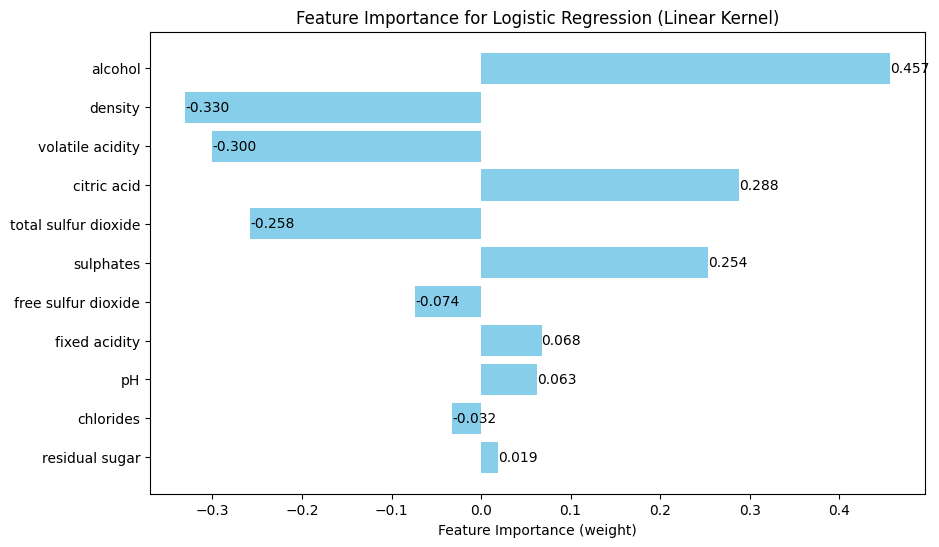

In [78]:
plot_feature_importance(feature_importance, X_red.columns)

## White Wine Quality Classification

### Train-Test Splitting

In [82]:
X_white = wine_white_transformed.drop("quality", axis=1)
y_white = wine_white_transformed["quality"]


In [83]:
X_white_train, X_white_test, y_white_train, y_white_test = train_test_split(X_white, y_white, test_size=0.2, random_state=42)                        

### SVM

In [92]:
svm = SVM(kernel='linear', learning_rate=0.001, n_iters=100)  # linear SVM with SGD

svm.fit(X_white_train, y_white_train, X_test=X_white_test, y_test = y_white_test)

preds_white_svm = svm.predict(X_white_test)
metrics = classification_metrics(y_white_test, preds_white_svm)
for k, v in metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")

Epoch 1: Train Loss=0.6286, Train Accuracy=0.7025 | Test Loss=0.6249, Test Accuracy=0.7068
Epoch 2: Train Loss=0.5963, Train Accuracy=0.7316 | Test Loss=0.6023, Test Accuracy=0.7171
Epoch 3: Train Loss=0.5877, Train Accuracy=0.7321 | Test Loss=0.5985, Test Accuracy=0.7211
Epoch 4: Train Loss=0.5849, Train Accuracy=0.7413 | Test Loss=0.5982, Test Accuracy=0.7273
Epoch 5: Train Loss=0.5841, Train Accuracy=0.7382 | Test Loss=0.5991, Test Accuracy=0.7283
Epoch 6: Train Loss=0.5843, Train Accuracy=0.7374 | Test Loss=0.6006, Test Accuracy=0.7273
Epoch 7: Train Loss=0.5847, Train Accuracy=0.7374 | Test Loss=0.6020, Test Accuracy=0.7293
Epoch 8: Train Loss=0.5855, Train Accuracy=0.7390 | Test Loss=0.6036, Test Accuracy=0.7242
Epoch 9: Train Loss=0.5866, Train Accuracy=0.7379 | Test Loss=0.6051, Test Accuracy=0.7242
Epoch 10: Train Loss=0.5878, Train Accuracy=0.7387 | Test Loss=0.6067, Test Accuracy=0.7252
Epoch 11: Train Loss=0.5893, Train Accuracy=0.7354 | Test Loss=0.6085, Test Accuracy=0.72

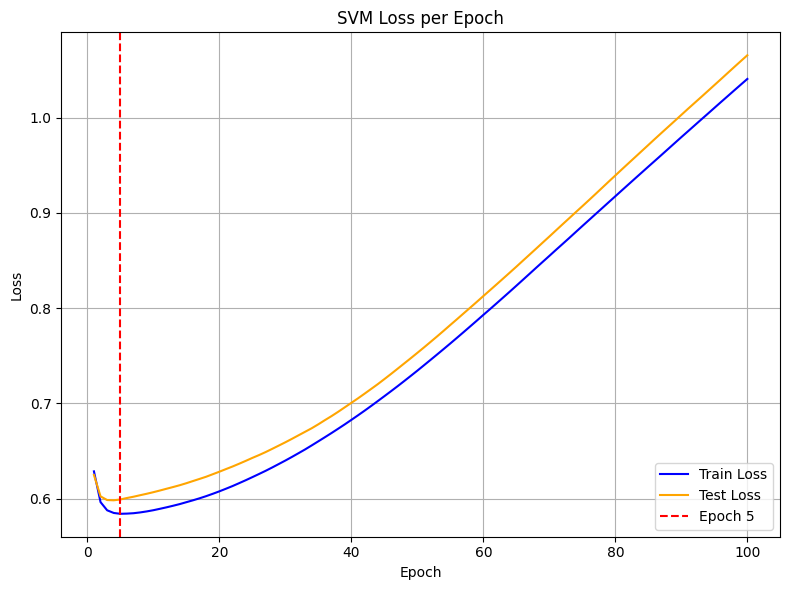

In [93]:
plot_model_loss(svm, vline_epoch=5, train_color='blue', test_color='orange')

### Logistic Regression

In [94]:
logreg = LogisticRegression(
    learning_rate=1e-5, n_iters=100, kernel='linear', gamma=0.1,
    positive_class='good', l2=0.001
)
logreg.fit(X_white_train, y_white_train, X_test=X_white_test, y_test = y_white_test)

preds_white_logreg = logreg.predict(X_white_test)
metrics = classification_metrics(y_white_test, preds_white_logreg)
for k, v in metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")

[Epoch 1/100] Train Loss: 0.6466 | Accuracy: 0.6632 || Test Loss: 0.6413 | Accuracy: 0.6721
[Epoch 2/100] Train Loss: 0.6405 | Accuracy: 0.6632 || Test Loss: 0.6346 | Accuracy: 0.6721
[Epoch 3/100] Train Loss: 0.6355 | Accuracy: 0.6632 || Test Loss: 0.6294 | Accuracy: 0.6721
[Epoch 4/100] Train Loss: 0.6312 | Accuracy: 0.6632 || Test Loss: 0.6249 | Accuracy: 0.6721
[Epoch 5/100] Train Loss: 0.6274 | Accuracy: 0.6632 || Test Loss: 0.6210 | Accuracy: 0.6721
[Epoch 6/100] Train Loss: 0.6241 | Accuracy: 0.6629 || Test Loss: 0.6176 | Accuracy: 0.6721
[Epoch 7/100] Train Loss: 0.6212 | Accuracy: 0.6627 || Test Loss: 0.6146 | Accuracy: 0.6731
[Epoch 8/100] Train Loss: 0.6186 | Accuracy: 0.6624 || Test Loss: 0.6119 | Accuracy: 0.6721
[Epoch 9/100] Train Loss: 0.6164 | Accuracy: 0.6632 || Test Loss: 0.6096 | Accuracy: 0.6721
[Epoch 10/100] Train Loss: 0.6144 | Accuracy: 0.6652 || Test Loss: 0.6075 | Accuracy: 0.6731
[Epoch 11/100] Train Loss: 0.6126 | Accuracy: 0.6645 || Test Loss: 0.6056 | Acc

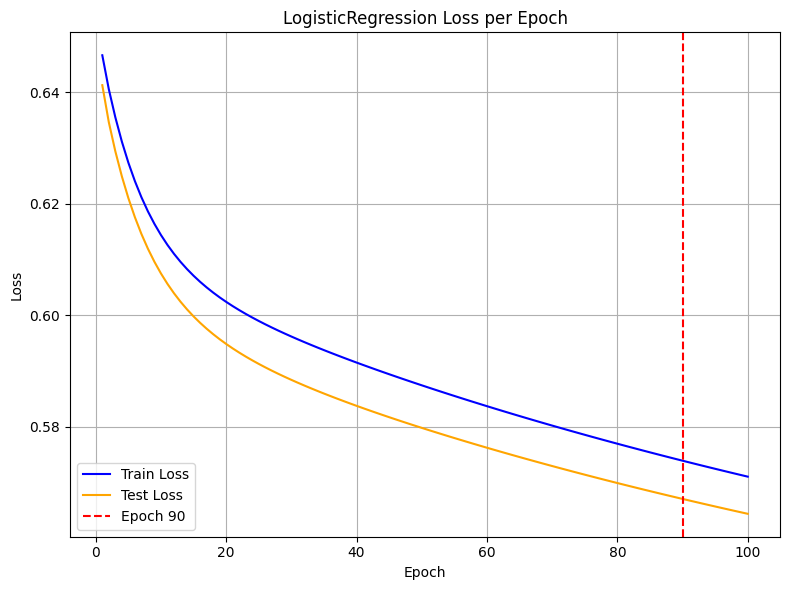

In [95]:
plot_model_loss(logreg, vline_epoch=90, train_color='blue', test_color='orange')

### Hyperparameter Tuning with CV & Model Comparison

In [ ]:
svm_param_grid = {
    'learning_rate':[0.01, 0.1],
    'lambda_l2':[0.001, 0.01],
    'kernel' :['rbf', 'poly'],
    'gamma' : [0.01, 0.1],
    'C' :[0.01, 0.1]
}

In [ ]:
svm_scores, svm_params = nested_cross_validation(
        X_white_train, y_white_train, svm, svm_param_grid, outer_k=5, inner_k=5, random_state=42
    )


In [ ]:
best_fold_idx = np.argmax(svm_scores)  
best_params = svm_params[best_fold_idx]

print("Best parameters (from best fold):", best_params)
print("Best fold score:", svm_scores[best_fold_idx])


In [ ]:
print("\nCross-validated performance:")
print(f"Mean accuracy: {np.mean(svm_scores):.3f} ± {np.std(svm_scores):.3f}")


In [ ]:
lr_param_grid = {
    'learning_rate':[0.01, 0.1],
    'l2':[0.001, 0.01],
    'kernel' :['linear', 'rbf', 'poly'],
    'gamma' : [0.01, 0.1],
    'degree': [2,3],
    'coef0': [1.0]

}

In [ ]:
lr_scores, lr_params = nested_cross_validation(
        X_white_train, y_white_train, logreg, lr_param_grid, outer_k=5, inner_k=5, random_state=42
    )

In [ ]:
best_fold_idx = np.argmax(lr_scores)  
best_params = lr_params[best_fold_idx]

print("Best parameters (from best fold):", best_params)
print("Best fold score:", lr_scores[best_fold_idx])


In [ ]:
print("\nCross-validated performance:")
print(f"Mean accuracy: {np.mean(lr_scores):.3f} ± {np.std(lr_scores):.3f}")

### Model Analysis

#### SVM

In [96]:
cm = confusion_matrix(y_white_test, preds_white_svm, positive_label='good')
cm

,Predicted good,Predicted not-good
Actual good,472,186
Actual not-good,156,165


In [97]:
svm_white_probs = svm.predict_proba(X_white_test)[:, 1]

In [98]:
fpr, tpr, auc = roc_auc_score(y_white_test, svm_white_probs, pos_label='good')

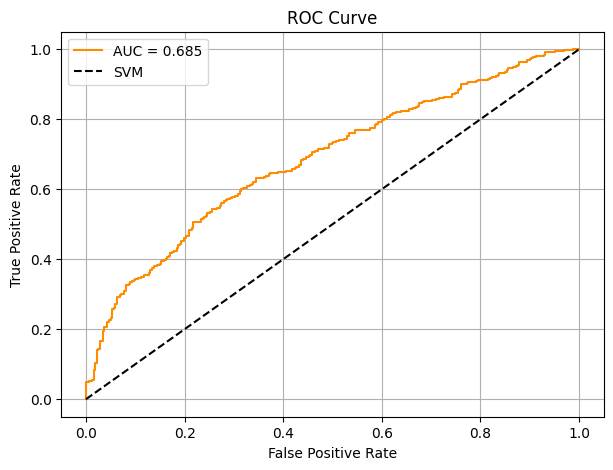

In [99]:
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}', color='darkorange')
plt.plot([0,1], [0,1], 'k--', label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

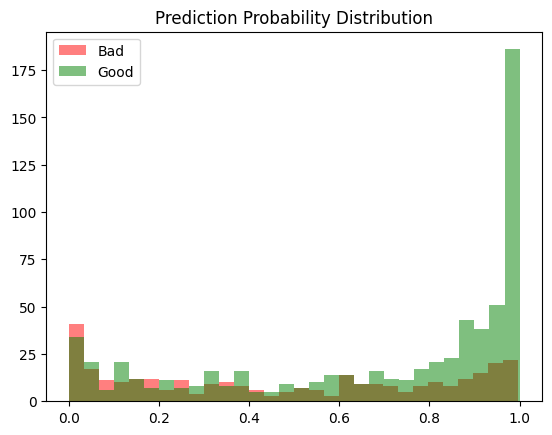

In [100]:
plt.hist(svm_white_probs[y_white_test == 'bad'], bins=30, alpha=0.5, label='Bad', color='red')
plt.hist(svm_white_probs[y_white_test == 'good'], bins=30, alpha=0.5, label='Good', color='green')
plt.title("Prediction Probability Distribution")
plt.legend()
plt.show()

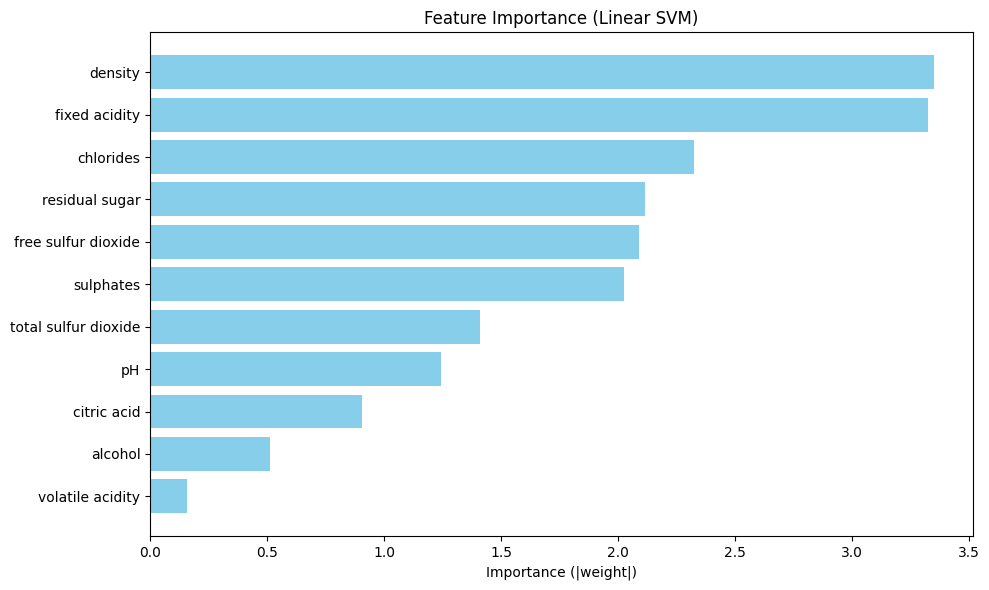

In [101]:
importances = svm.get_feature_importance(X_white.columns)
sorted_items = sorted(importances.items(), key=lambda x: -x[1])
features, values = zip(*sorted_items)

plt.figure(figsize=(10, 6))
plt.barh(features, values, color='skyblue')
plt.xlabel('Importance (|weight|)')
plt.title('Feature Importance (Linear SVM)')
plt.gca().invert_yaxis()  # Highest on top
plt.tight_layout()
plt.show()

#### Logistic Regression

In [102]:
cm = confusion_matrix(y_white_test, preds_white_logreg, positive_label='good')
cm

,Predicted good,Predicted not-good
Actual good,589,69
Actual not-good,251,70


In [104]:
logreg_white_probs = logreg.predict_proba(X_white_test)

In [105]:
fpr, tpr, auc = roc_auc_score(y_white_test, logreg_white_probs, pos_label='good')

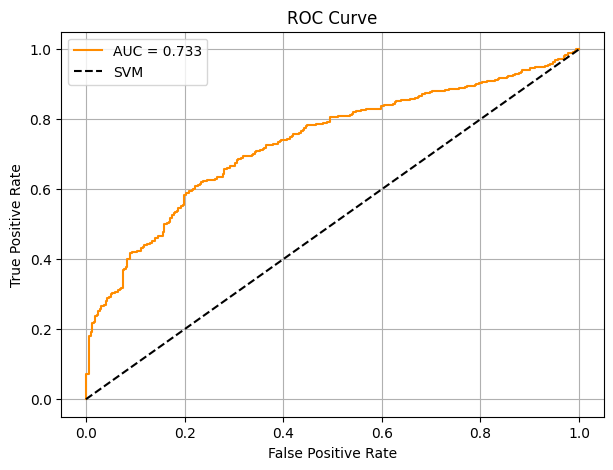

In [106]:
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}', color='darkorange')
plt.plot([0,1], [0,1], 'k--', label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

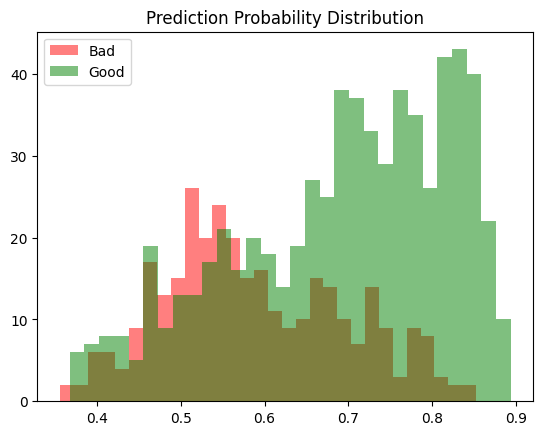

In [107]:
plt.hist(logreg_white_probs[y_white_test == 'bad'], bins=30, alpha=0.5, label='Bad', color='red')
plt.hist(logreg_white_probs[y_white_test == 'good'], bins=30, alpha=0.5, label='Good', color='green')
plt.title("Prediction Probability Distribution")
plt.legend()
plt.show()

In [ ]:
feature_importance = logreg.get_feature_importance()


In [ ]:
plot_feature_importance(feature_importance, X_red.columns)